In [1]:
"""Data inspection."""

'Data inspection.'

In [115]:
import csv
import glob
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation
import nibabel
import os
import sklearn
import shutil

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

import importlib
import analyze
importlib.reload(analyze)
import datasets
importlib.reload(datasets)
import vis
importlib.reload(vis)

CRYO_DIR = '/cryo/'
TRAIN_VAL_DIR = os.path.join(CRYO_DIR, 'train_val_datasets')
OUTPUT = '/scratch/users/nmiolane/output'
DEVICE = 'cuda'

IMG_SHAPE = (128, 128)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)
TRAIN_IMG_PATH = os.path.join(TRAIN_VAL_DIR, 'cryo_sim_%s.npy' % SHAPE_STR)
TRAIN_LABELS_PATH = os.path.join(TRAIN_VAL_DIR, 'cryo_sim_labels_%s.csv' % SHAPE_STR)

Loading /cryo/train_val_datasets/cryo_sim_128x128.npy
Dataset shape: (2544, 1, 128, 128)


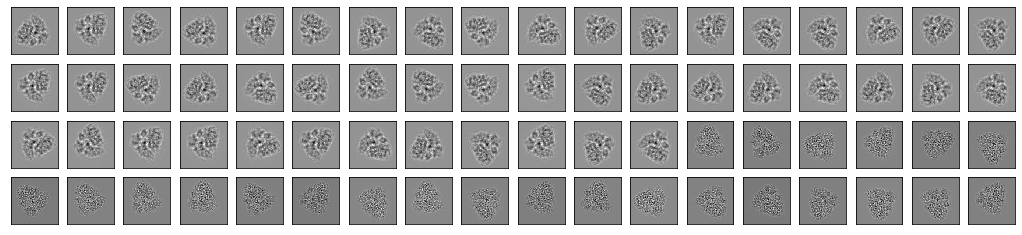

In [21]:
vis.show_data(TRAIN_IMG_PATH)

### Inspect training

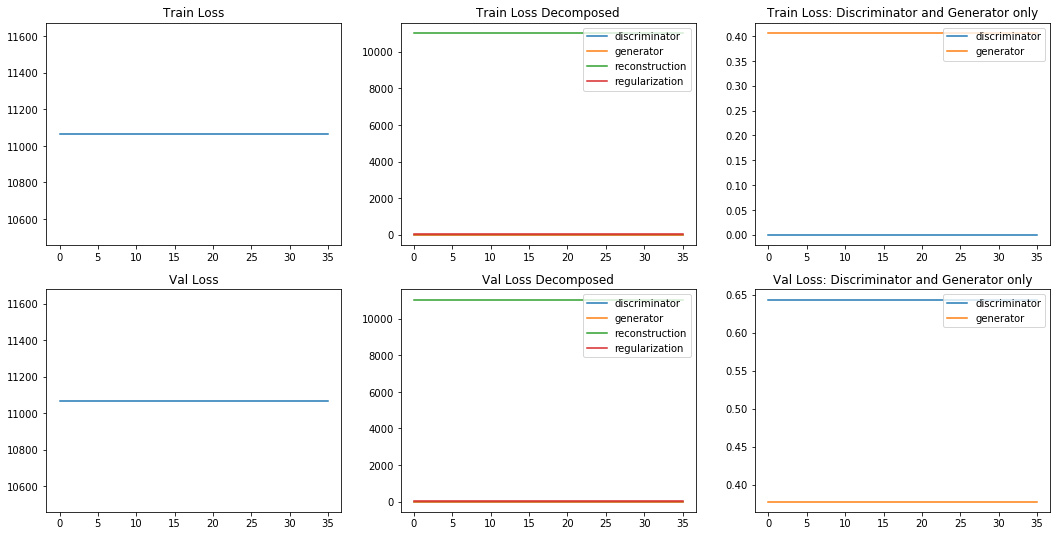

In [22]:
epoch_id = 35
vis.plot_losses(OUTPUT, epoch_id=epoch_id)

# 2. Inspect the latent space

Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_49_encoder_train_loss_11054.3421_val_loss_11058.2766.pth
Standard deviation explained by PC 0
1.5540693
Standard deviation explained by PC 1
1.5160496


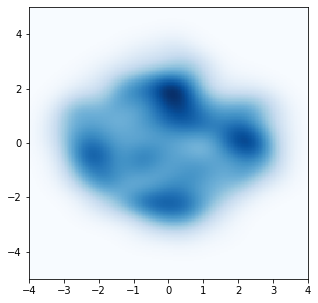

In [38]:
N_PCA_COMPONENTS = 2

dataset = np.load(TRAIN_IMG_PATH)
mus = analyze.latent_projection(OUTPUT, dataset)
projected_mus = analyze.pca_projection(mus, N_PCA_COMPONENTS)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

ax = analyze.plot_kde(ax, projected_mus)
#cb = plt.colorbar()
#cb.set_label("density")

for i in range(N_PCA_COMPONENTS):
    print('Standard deviation explained by PC %d' % i)
    mus = projected_mus[:,i]
    print(np.std(mus))

In [97]:
def get_cryo(img_path, labels_path, n_pc=2):
    focuses = []

    with open(labels_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            focuses.append(float(row[0]))
        
    test_dataset = np.load(img_path)

    # Note: the test dataset needs to be unshuffled here
    mus = analyze.latent_projection(OUTPUT, test_dataset)
    projected_mus = analyze.pca_projection(mus, n_pc)

    return projected_mus, focuses

In [100]:
FOCUS_MAX = 3.
start = 0.5
by = 0.5
num = int((FOCUS_MAX - start) / by + 1)
colormap = cm.get_cmap('viridis')
COLORS = colormap(np.linspace(start=0, stop=1, num=num))
print(COLORS)

def plot_cryo(ax, img_path, labels_path, n_pc=2):
    projected_mus, focuses = get_cryo(img_path, labels_path, n_pc=n_pc)

    for mu, focus in zip(projected_mus, focuses):
        color_id = int(2 * focus) - 1
        if n_pc == 2:
            im = ax.scatter(mu[0], mu[1], c=np.array([COLORS[color_id]]), s=4)
        else:
            im = ax.scatter(mu[0], mu[1], mu[2], c=np.array([COLORS[color_id]]))
    return im, ax

[[0.267004 0.004874 0.329415 1.      ]
 [0.253935 0.265254 0.529983 1.      ]
 [0.163625 0.471133 0.558148 1.      ]
 [0.134692 0.658636 0.517649 1.      ]
 [0.477504 0.821444 0.318195 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


# 2D

Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_100_encoder_train_loss_11036.8004_val_loss_11041.4333.pth


[Text(1, 0, '0.5'),
 Text(1, 0, '1.0'),
 Text(1, 0, '1.5'),
 Text(1, 0, '2.0'),
 Text(1, 0, '2.5'),
 Text(1, 0, '3.0')]

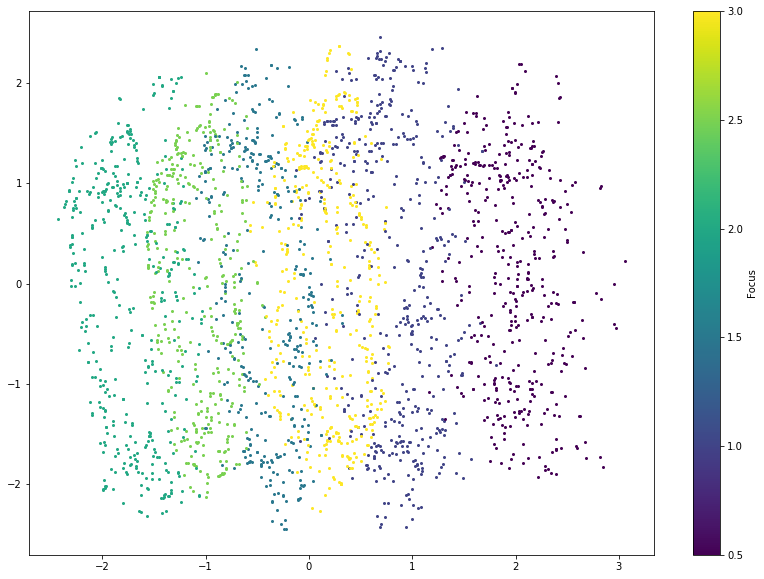

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))

im, ax = plot_cryo(ax, TRAIN_IMG_PATH, TRAIN_LABELS_PATH)
cb = fig.colorbar(im, ax=ax)
cb.set_label('Focus')
cb.ax.set_yticklabels(np.arange(start=0.5, stop=3.5, step=0.5))

# 3D

Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_100_encoder_train_loss_11036.8004_val_loss_11041.4333.pth


[Text(1, 0, '0.5'),
 Text(1, 0, '1.0'),
 Text(1, 0, '1.5'),
 Text(1, 0, '2.0'),
 Text(1, 0, '2.5'),
 Text(1, 0, '3.0')]

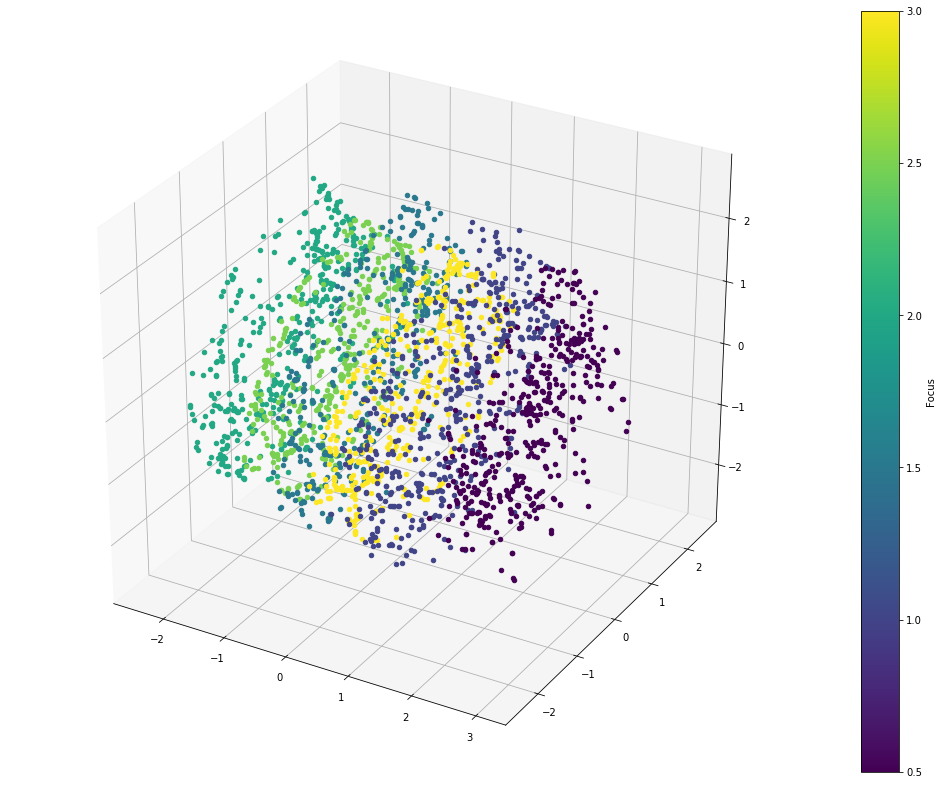

In [111]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111, projection='3d')

im, ax = plot_cryo(ax, TRAIN_IMG_PATH, TRAIN_LABELS_PATH, n_pc=3)
cb = fig.colorbar(im, ax=ax)
cb.set_label('Focus')
cb.ax.set_yticklabels(np.arange(start=0.5, stop=3.5, step=0.5))

### Interactive exploration of PCA in each cluster

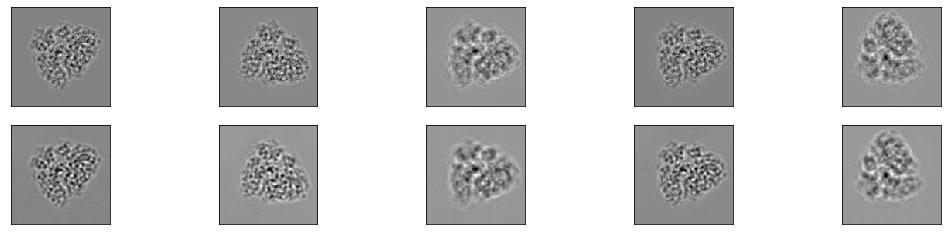

In [116]:
vis.plot_img_and_recon(OUTPUT, epoch_id=100, cmap='gray')

# 3. Inspect report created by pipeline

In [49]:
import os
import pylab

report_dir = '/scratch/users/nmiolane/output/report'
losses_path = os.path.join(report_dir, 'losses.png')
images_path = os.path.join(report_dir, 'images.png')
report_path = os.path.join(report_dir, 'report.html')

plt.figure()
img = pylab.imread(losses_path)
plt.imshow(img, aspect='auto')
plt.axis('off')

plt.figure(figsize=(30, 60))
img = pylab.imread(images_path)
plt.imshow(img)
plt.axis('off')


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/nmiolane/output/report/losses.png'

<Figure size 432x288 with 0 Axes>

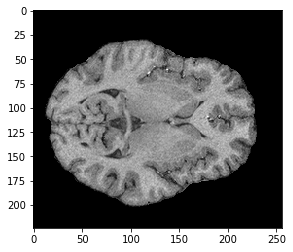

In [3]:
import nibabel
path = '/tmp/_oyiw_36_defBrainExtractionBrain.nii.gz'
img = nibabel.load(path)
array = img.get_fdata()
array = np.nan_to_num(array)
plt.imshow(array[:,:,120], cmap='gray')